<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Multi-Agent-Deep-Deterministic-Policy-Gradients-(DDPG)" data-toc-modified-id="Multi-Agent-Deep-Deterministic-Policy-Gradients-(DDPG)-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Multi-Agent Deep Deterministic Policy Gradients (DDPG)</a></span><ul class="toc-item"><li><span><a href="#Import-the-Necessary-Packages" data-toc-modified-id="Import-the-Necessary-Packages-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Import the Necessary Packages</a></span></li><li><span><a href="#Instantiate-the-Environment-and-Agent" data-toc-modified-id="Instantiate-the-Environment-and-Agent-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Instantiate the Environment and Agent</a></span><ul class="toc-item"><li><span><a href="#Examine-the-state-and-action-spaces" data-toc-modified-id="Examine-the-state-and-action-spaces-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>Examine the state and action spaces</a></span></li></ul></li><li><span><a href="#Train-the-Agents-with-MADDPG" data-toc-modified-id="Train-the-Agents-with-MADDPG-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Train the Agents with MADDPG</a></span></li></ul></li></ul></div>

# Multi-Agent Deep Deterministic Policy Gradients (DDPG)
---
In this notebook, we train MADDPG with Udacity's Tennis environment.

## Import the Necessary Packages

In [1]:
from unityagents import UnityEnvironment
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

import importlib

import ddpg_agent
import prioritized_ddpg_agent

importlib.reload(prioritized_ddpg_agent)

<module 'prioritized_ddpg_agent' from 'C:\\Users\\thoma\\Documents\\GitHub\\deep-reinforcement-learning\\p3_collab-compet\\prioritized_ddpg_agent.py'>

## Instantiate the Environment and Agent

In [2]:
env = UnityEnvironment(file_name='Tennis_Windows_x86_64/Tennis.exe')

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Creating functions for common environment processes

In [3]:
def environment_step(env, action, brain_name):
    env_info = env.step(action)[brain_name]
    next_states = env_info.vector_observations   # get the next state
    rewards = env_info.rewards                   # get the reward
    dones = env_info.local_done 
    
    return next_states, rewards, dones, None

def environment_reset(env, brain_name, train_mode=True):
    env_info = env.reset(train_mode=train_mode)[brain_name] # reset the environment
    
    return env_info

### Examine the state and action spaces

In [4]:
# reset the environment
env_info = environment_reset(env, brain_name)

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


## Train the Agents with MADDPG

Run the code cell below to train the agent from scratch.  Alternatively, you can skip to the next code cell to load the pre-trained weights from file.

In [52]:
import prioritized_ddpg_agent
importlib.reload(prioritized_ddpg_agent)
importlib.reload(ddpg_agent)

#agent = prioritized_ddpg_agent.PrioritizedAgent(state_size=state_size, action_size=action_size, random_seed=42)
#agent = ddpg_agent.Agent(
#    per_agent_state_size = state_size, 
#    per_agent_action_size = action_size, 
#    full_state_size = num_agents * state_size,
#    full_action_size = num_agents * action_size,
#    num_agents = num_agents,
#    random_seed=42)

agent = ddpg_agent.MADDPG(
    state_size,
    action_size,
    num_agents,
    random_seed=42
)
agent.act(states,0, add_noise=True)

array([[ 0.33537695, -0.21658804],
       [-0.7896132 ,  0.16463876]], dtype=float32)

In [53]:
import time

In [54]:
def ddpg(n_episodes=10000, max_t=int(1e6), solved_score=0.5, consec_episodes=100, print_every=1, train_mode=True,
         actor_path='actor_ckpt.pth', critic_path='critic_ckpt.pth'):
    """Deep Deterministic Policy Gradient (DDPG)
    
    Params
    ======
        n_episodes (int)      : maximum number of training episodes
        max_t (int)           : maximum number of timesteps per episode
        train_mode (bool)     : if 'True' set environment to training mode
        solved_score (float)  : min avg score over consecutive episodes
        consec_episodes (int) : number of consecutive episodes used to calculate score
        print_every (int)     : interval to display results
        actor_path (str)      : directory to store actor network weights
        critic_path (str)     : directory to store critic network weights

    """
    mean_scores = []                               # list of mean scores from each episode
    min_scores = []                                # list of lowest scores from each episode
    max_scores = []                                # list of highest scores from each episode
    best_score = -np.inf
    scores_window = deque(maxlen=consec_episodes)  # mean scores from most recent episodes
    moving_avgs = []                               # list of moving averages
    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=train_mode)[brain_name] # reset environment
        states = env_info.vector_observations                   # get current state for each agent      
        scores = np.zeros(num_agents)                           # initialize score for each agent
        agent.reset()
        start_time = time.time()
        for t in range(max_t):
            
            actions = agent.act(states, i_episode, add_noise=True)         # select an action
            next_states, rewards, dones, _ = environment_step(env, actions, brain_name)
            
            # save experience to replay buffer & perform learning step if current timesteps allows it
            #for state, action, reward, next_state, done in zip(states, actions, rewards, next_states, dones):
            agent.step(states, actions, rewards, next_states, dones, i_episode)             
            states = next_states
            scores += rewards
                        
            if np.any(dones):                                   # exit loop when episode ends
                break

        duration = time.time() - start_time
        min_scores.append(np.min(scores))             # save lowest score
        max_scores.append(np.max(scores))             # save highest score    
        mean_scores.append(np.mean(scores))           # save mean score for the episode
        scores_window.append(mean_scores[-1])         # save mean score to deque
        moving_avgs.append(np.mean(scores_window))    # save moving average from the 100 sized deque
                
        if i_episode % print_every == 0:
            print('\rEpisode {} ({} sec)  -- \tMin: {:.2f}\tMax: {:.2f}\tMean: {:.2f}\tMov. Avg: {:.2f}'.format(\
                  i_episode, round(duration), min_scores[-1], max_scores[-1], mean_scores[-1], moving_avgs[-1]))
                  
        if moving_avgs[-1] >= solved_score and i_episode >= consec_episodes:
            print('\nEnvironment SOLVED in {} episodes!\tMoving Average ={:.2f} over last {} episodes'.format(\
                                    i_episode-consec_episodes, moving_avgs[-1], consec_episodes))            
            if train_mode:
                agent.save_maddpg()
            break
            
    return mean_scores, moving_avgs

In [55]:
scores, avgs = ddpg()

Episode 1 (0 sec)  -- 	Min: -0.01	Max: 0.00	Mean: -0.00	Mov. Avg: -0.00
Episode 2 (0 sec)  -- 	Min: -0.01	Max: 0.00	Mean: -0.00	Mov. Avg: -0.00
Episode 3 (0 sec)  -- 	Min: -0.01	Max: 0.00	Mean: -0.00	Mov. Avg: -0.00
Episode 4 (0 sec)  -- 	Min: -0.01	Max: 0.00	Mean: -0.00	Mov. Avg: -0.00
Episode 5 (0 sec)  -- 	Min: -0.01	Max: 0.10	Mean: 0.05	Mov. Avg: 0.01
Episode 6 (0 sec)  -- 	Min: -0.01	Max: 0.00	Mean: -0.00	Mov. Avg: 0.00
Episode 7 (0 sec)  -- 	Min: 0.00	Max: 0.09	Mean: 0.05	Mov. Avg: 0.01
Episode 8 (0 sec)  -- 	Min: -0.01	Max: 0.00	Mean: -0.00	Mov. Avg: 0.01
Episode 9 (0 sec)  -- 	Min: -0.01	Max: 0.00	Mean: -0.00	Mov. Avg: 0.01
Episode 10 (0 sec)  -- 	Min: -0.01	Max: 0.10	Mean: 0.05	Mov. Avg: 0.01
Episode 11 (0 sec)  -- 	Min: -0.01	Max: 0.00	Mean: -0.00	Mov. Avg: 0.01
Episode 12 (0 sec)  -- 	Min: -0.01	Max: 0.00	Mean: -0.00	Mov. Avg: 0.01
Episode 13 (0 sec)  -- 	Min: -0.01	Max: 0.10	Mean: 0.05	Mov. Avg: 0.01
Episode 14 (0 sec)  -- 	Min: -0.01	Max: 0.00	Mean: -0.00	Mov. Avg: 0.01
Ep

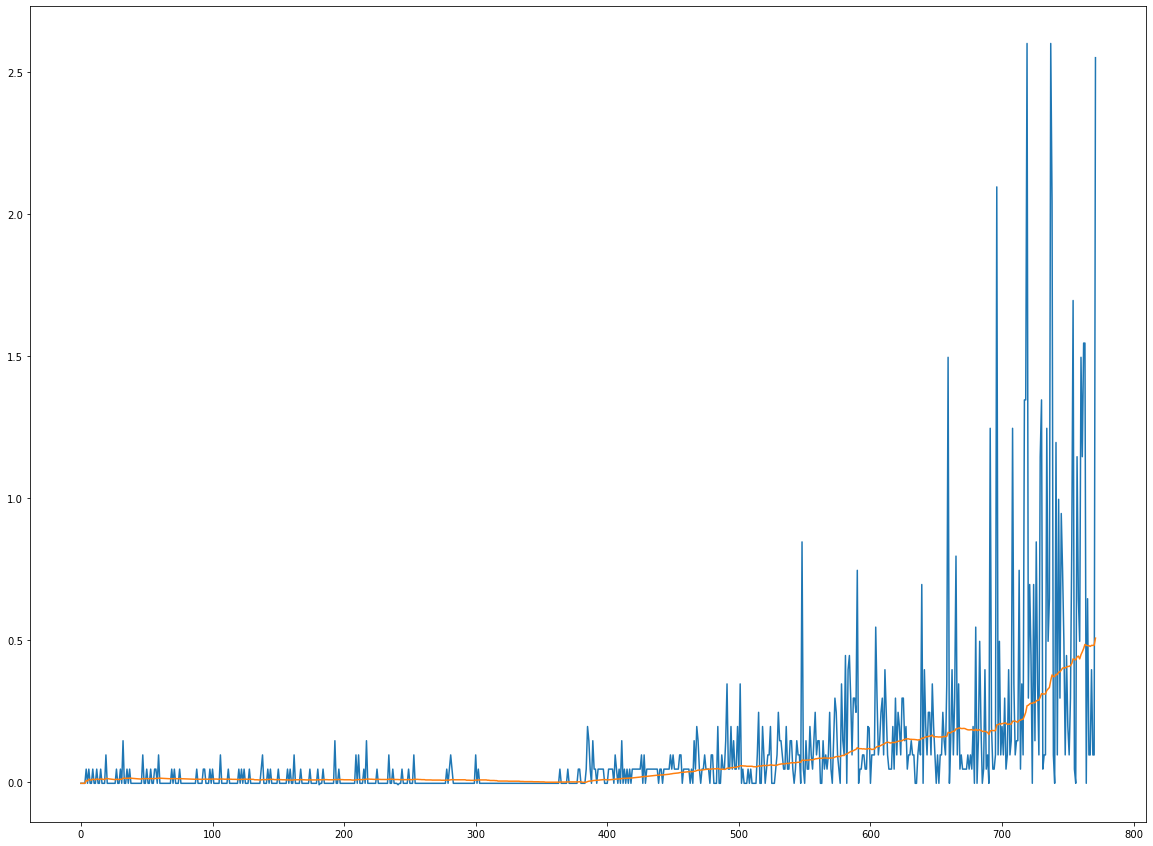

In [56]:
plt.figure(figsize=(20,15))
plt.plot(scores)
plt.plot(avgs)